#### RNN for Text Classification

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.

<img src=http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg>

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN (recurrent neural network), capable of learning long-term dependencies. RNNs are useful when we have a sequential data like text or, time series. As mentioned in https://colah.github.io/posts/2015-08-Understanding-LSTMs/

"Humans don’t start their thinking from scratch every second. As you read this essay, you understand each word based on your understanding of previous words. You don’t throw everything away and start thinking from scratch again. Your thoughts have persistence."

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

<img src=http://dprogrammer.org/wp-content/uploads/2019/04/RNN-vs-LSTM-vs-GRU-1024x308.png>

A typical LSTM network for text classification looks like - 

1. An embedding layer to learn embedding for each word in each text
2. LSTM/GRU/RNN layer consisting multiple cells to identify hidden semantics for each word given previous words. Bidirectional cells are used to use hidden information from both previous and after words.
3. Dense layer to consolidate all the information at the text level
4. Output layer (softmax/sigmoid) to get final output

### How to prepare dataset for RNN

Similar to any other modelling technique, we need to preprocess our input for RNN. 

1. We need to tokenize each text
2. Fix a maximum length allowed for all the texts (this can also be avoided, as RNNs can handle variable length text)
3. Pad texts with some static token id to make all the texts of same length
4. Get a word index and prepare embedding matrix
5. Create one hot encoded output

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = -1

df = pd.read_csv('clinical_notes_cleaned_pos.csv') #for excel file use read_excel

In [2]:
df.head(5)

text  \
0  \n \n \n \n \n <B>CC:</B> Difficulty with word finding.\n \n <B>HX: </B>This 27y/o RHF experienced sudden onset word finding difficulty and slurred speech on the evening of 2/19/96. She denied any associated dysphagia, diplopia, numbness or weakness of her extremities. She went to sleep with her symptoms on 2/19/96, and awoke with them on 2/20/96. She also awoke with a headache (HA) and mild neck stiffness. She took a shower and her HA and neck stiffness resolved. Throughout the day she continued to have difficulty with word finding and had worsening of her slurred speech. That evening, she began to experience numbness and weakness in the lower right face. She felt like there was a &quot;rubber-band&quot; wrapped around her tongue.\n \n For 3 weeks prior to presentation, she experienced transient episodes of a &quot;boomerang&quot; shaped field cut in the left eye. The episodes were not associated with any other symptoms. One week prior to presentation, she went to a local ER for menorrhagia. She had just resumed taking oral birth control pills one week prior to the ER visit after having stopped their use for several months. Local evaluation included an unremarkable carotid duplex scan. However, a HCT with and without contrast reportedly revealed a left frontal gyriform enhancing lesion. An MRI brain scan on 2/20/96 revealed nonspecific white matter changes in the right periventricular region. EEG reportedly showed diffuse slowing. CRP was reportedly &quot;too high&quot; to calibrate.\n \n <B>MEDS:</B> Ortho-Novum 7-7-7 (started 2/3/96), and ASA (started 2/20/96).\n \n <B>PMH:</B> 1)ventral hernia repair 10 years ago, 2)mild &quot;concussion&quot; suffered during a MVA; without loss of consciousness, 5/93, 3) Anxiety disorder, 4) One childbirth.\n \n <B>FHX: </B>She did not know her father and was not in contact with her mother.\n \n <B>SHX:</B> Lives with boyfriend. Smokes one pack of cigarettes every three days and has done so for 10 years. Consumes 6 bottles of beers, one day a week. Unemployed and formerly worked at an herbicide plant.\n \n <B>EXAM: </B>BP150/79, HR77, RR22, 37.4C.\n \n MS: A&O to person, place and time. Speech was dysarthric with mild decreased fluency marked by occasional phonemic paraphasic errors. Comprehension, naming and reading were intact. She was able to repeat, though her repetition was occasionally marked by phonemic paraphasic errors. She had no difficulty with calculation.\n \n CN: VFFTC, Pupils 5/5 decreasing to 3/3. EOM intact. No papilledema or hemorrhages seen on fundoscopy. No RAPD or INO. There was right lower facial weakness. Facial sensation was intact, bilaterally. The rest of the CN exam was unremarkable.\n \n MOTOR: 5/5 strength throughout with normal muscle bulk and tone.\n \n Sensory: No deficits.\n \n Coord/Station/Gait: unremarkable.\n \n Reflexes 2/2 throughout. Plantar responses were flexor, bilaterally.\n \n Gen Exam: unremarkable.\n \n <B>COURSE:</B> CRP 1.2 (elevated), ESR 10, RF 20, ANA 1:40, ANCA &lt;1:40, TSH 2.0, FT4 1.73, Anticardiolipin antibody IgM 10.8GPL units (normal &lt;10.9), Anticardiolipin antibody IgG 14.8GPL (normal&lt;22.9), SSA and SSB were normal. Urine beta-hCG pregnancy and drug screen were negative. EKG, CXR and UA were negative.\n \n MRI brain, 2/21/96 revealed increased signal on T2 imaging in the periventricular white matter region of the right hemisphere. In addition, there were subtle T2 signal changes in the right frontal, right parietal, and left parietal regions as seen previously on her local MRI can. In addition, special FLAIR imaging showed increased signal in the right frontal region consistent with ischemia.\n \n She underwent Cerebral Angiography on 2/22/96. This revealed decreased flow and vessel narrowing the candelabra branches of the RMCA supplying the right frontal lobe. These changes corresponded to the areas of ischemic changes seen on MRI. There was also segmental narrowing of the caliber of the vessels in the circle of

In [3]:
df['word_len'] = df.clean_text.apply(lambda x: len(x.split()))
df['word_len'].describe()

count    818.000000 
mean     323.909535 
std      241.449720 
min      39.000000  
25%      163.000000 
50%      276.000000 
75%      420.250000 
max      3026.000000
Name: word_len, dtype: float64

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.models import Sequential, Model
import tensorflow as tf
import keras.backend as K

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

Using TensorFlow backend.


Before feeding the data into NN, we need to tokenize the data and make all the texts of same length. We pass max_len as the maximum length of the text to be passed in the NN. If a text has < max_len number of words, we pad with blank word. For longer texts we will restrict it to max_len.

In [5]:
max_features = 20000
max_len = 200

In [6]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df.clean_text.values)
X = tokenizer.texts_to_sequences(df.clean_text.values)
X = pad_sequences(X,maxlen=max_len,padding='post')

In [7]:
print (X.shape)

(818, 200)


In [8]:
X[0]

array([ 114,  469,    2,  530,  164,  168, 1655,  162,  576, 2552,    8,
        815,  393,   42,  135,  618,  332, 1565, 6014,  606, 3459, 2160,
          2,  530,  407,   53, 3747,   40,  998,   53,   21,   92, 2553,
        870, 1338,  332, 4546, 5161,   74,  685, 1174, 4547, 1565, 4122,
        190, 2554,   98, 4548, 1339,  893,  218, 1042, 1938,    8,  999,
        393, 2430, 2555,  105,   42,   52, 2556, 6015,   53, 2161,  149,
         36,   42, 1090,  850,  462,  154,  288, 1407,  599,   32,  697,
       6016, 2162,   32, 3748,    8,  789,  393,  162,    2,  530,  185,
        183, 1872,  105,   42,   52,  600, 2163,  560, 1696,   52, 1938,
         37,  185,  183,  176,   38,  420, 1562,  846,    2, 1271, 6017,
        246,  307, 1364,  816,  605,   41,  746,  168,  600,   95,    3,
       1406,    8,  708,  393,   92,  185,  148,   42,  832,  114,  469,
        849,  319,  150, 3746, 1091,    3, 6018, 2851,  408,  530, 2851,
        137,  168, 1938,  301, 6019, 1272, 2678,   

In [9]:
word_index = tokenizer.word_index

In [10]:
word_index

{'patient': 1,
 'right': 2,
 'left': 3,
 '1': 4,
 'normal': 5,
 'use': 6,
 'place': 7,
 '2': 8,
 'pain': 9,
 '0': 10,
 '5': 11,
 '3': 12,
 '4': 13,
 'procedure': 14,
 'note': 15,
 'time': 16,
 'year': 17,
 'take': 18,
 'history': 19,
 'low': 20,
 'see': 21,
 'leave': 22,
 'incision': 23,
 'perform': 24,
 '10': 25,
 'remove': 26,
 'skin': 27,
 'mm': 28,
 'position': 29,
 'make': 30,
 'extremity': 31,
 'mg': 32,
 'lateral': 33,
 'anterior': 34,
 'present': 35,
 'day': 36,
 'follow': 37,
 'room': 38,
 'old': 39,
 'area': 40,
 'unremarkable': 41,
 'reveal': 42,
 'tissue': 43,
 'show': 44,
 'nerve': 45,
 'mild': 46,
 'suture': 47,
 '6': 48,
 'blood': 49,
 'posterior': 50,
 'give': 51,
 'evidence': 52,
 'change': 53,
 'obtain': 54,
 'distal': 55,
 'level': 56,
 'side': 57,
 'cm': 58,
 'two': 59,
 'one': 60,
 'appear': 61,
 'general': 62,
 'anesthesia': 63,
 'vicryl': 64,
 'head': 65,
 'identify': 66,
 'close': 67,
 'bone': 68,
 'muscle': 69,
 'joint': 70,
 'significant': 71,
 'postoperative'

We build a simple LSTM network with 1 layer with 200 dimensional word embeddings as input and 256 dimensional output for each temporal token. We further use average of LSTM outputs and feed that into the final dense layer.

In [11]:
embed_dim = 200 #dimension of the embedding
lstm_out = 200 #dimension of the lstm output 
n_layers = 1 #number of LSTM layers
n_output = df.label.nunique() #number of possible outputs

We use PubMed embedding in the embedding layer

In [12]:
from tqdm import tqdm

embeddings_index = {}
f = open('pubmed_wv.txt','r',encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    if coefs.shape[0] == embed_dim and word in word_index:
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2665548it [04:42, 9422.72it/s] 

Found 10673 word vectors.


In [13]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
y = pd.get_dummies(df.label).values
y_labels = list(pd.get_dummies(df.label).columns)

In [15]:
int_to_label = {i:y_labels[i] for i in range(len(y_labels))}

In [16]:
for train_idx, val_idx in StratifiedKFold(n_splits=5,random_state=42).split(X,df.label):
    break

In [17]:
batch_size = 64
n_epochs = 50

In [18]:
print (X.shape, y.shape)

(818, 200) (818, 5)


In [19]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [24]:
def get_model():
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, embed_dim,input_length = X.shape[1], weights=[embedding_matrix], trainable=False))
    #model.add(SpatialDropout1D(0.4))
    model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, return_sequences=True)))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(.2))
    model.add(Dense(n_output,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=.0001),metrics = ['accuracy',f1])
    #print(model.summary())
    return model

In [25]:
model = get_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 200)          2224400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 400)          641600    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 400)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2005      
Total params: 2,868,005
Trainable params: 643,605
Non-trainable params: 2,224,400
_________________________________________________________________


Let us put all inside a class

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

class KerasTextClassifier(BaseEstimator, TransformerMixin):
    '''Wrapper class for keras text classification models that takes raw text as input.'''

    def __init__(self, max_words=20000, input_length=X.shape[1], emb_dim=embed_dim, n_classes=n_output, epochs=n_epochs, batch_size=batch_size, embedding_matrix=embedding_matrix):
        self.max_words = max_words
        self.input_length = input_length
        self.emb_dim = emb_dim
        self.n_classes = n_classes
        self.epochs = epochs
        self.bs = batch_size
        self.embedding_matrix = embedding_matrix
        self.tokenizer = Tokenizer(num_words=self.max_words+1, lower=True, split=' ')
        self.model = self._get_model()
        return self.model.summary()

    def _get_model(self):
        model = Sequential()
        model.add(Embedding(len(word_index) + 1, embed_dim,input_length = self.input_length, weights=[self.embedding_matrix], trainable=False))
        #model.add(SpatialDropout1D(0.4))
        model.add(LSTM(lstm_out, dropout=0.2, return_sequences=True))
        model.add(GlobalAveragePooling1D())
        model.add(Dropout(.2))
        model.add(Dense(n_output,activation='softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=.0001),metrics = ['accuracy',f1])
        #print(model.summary())
        return model

        return get_model()

    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.input_length, value=0, padding='post')

    def _preprocess(self, X, y):
        '''Fit the vocabulary and the model.
           :params: X: list of texts. y: labels.
        '''
        self.tokenizer.fit_on_texts(X)
        self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
        self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
        seqs = self._get_sequences(X)
        self.seqs = seqs
        self.texts = X
        self.y = y
        
    def fit(self, train_idx, val_idx):
        
        early = EarlyStopping(monitor='val_f1', min_delta=0, patience=7, verbose=0, mode='max', baseline=None, restore_best_weights=False)
        lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)
        checkpointer = ModelCheckpoint(monitor='val_f1',filepath='weights_lstm.hdf5', mode='max',verbose=1, save_best_only=True)
    
        self.history = self.model.fit(self.seqs[train_idx], self.y[train_idx], batch_size=self.bs, epochs=self.epochs, validation_data=(self.seqs[val_idx], self.y[val_idx]), callbacks=[early,lr,checkpointer], verbose=2)

    def predict_proba(self, X, y=None):
        seqs = self._get_sequences(X)
        return self.model.predict(seqs)

    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y.argmax(1), y_pred), f1_score(y.argmax(1), y_pred, average='macro')
    

In [27]:
text_model = KerasTextClassifier()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          2224400   
_________________________________________________________________
lstm_4 (LSTM)                (None, 200, 200)          320800    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1005      
Total params: 2,546,205
Trainable params: 321,805
Non-trainable params: 2,224,400
_________________________________________________________________


In [28]:
text_model._preprocess(df.clean_text.values,y)

In [29]:
text_model.fit(train_idx,val_idx)


Train on 652 samples, validate on 166 samples
Epoch 1/50
 - 13s - loss: 1.6035 - accuracy: 0.2408 - f1: 0.0000e+00 - val_loss: 1.5773 - val_accuracy: 0.2831 - val_f1: 0.0000e+00

Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to weights_lstm.hdf5
Epoch 2/50
 - 13s - loss: 1.5533 - accuracy: 0.2975 - f1: 0.0000e+00 - val_loss: 1.5415 - val_accuracy: 0.2711 - val_f1: 0.0000e+00

Epoch 00002: val_f1 did not improve from 0.00000
Epoch 3/50
 - 15s - loss: 1.5231 - accuracy: 0.2822 - f1: 0.0000e+00 - val_loss: 1.5122 - val_accuracy: 0.2711 - val_f1: 0.0000e+00

Epoch 00003: val_f1 did not improve from 0.00000
Epoch 4/50
 - 13s - loss: 1.4860 - accuracy: 0.2837 - f1: 0.0028 - val_loss: 1.4782 - val_accuracy: 0.2892 - val_f1: 0.0000e+00

Epoch 00004: val_f1 did not improve from 0.00000
Epoch 5/50
 - 13s - loss: 1.4381 - accuracy: 0.3282 - f1: 0.0061 - val_loss: 1.4273 - val_accuracy: 0.3373 - val_f1: 0.0235

Epoch 00005: val_f1 improved from 0.00000 to 0.02353, saving model t


Epoch 00042: val_f1 did not improve from 0.71162
Epoch 43/50
 - 10s - loss: 0.6009 - accuracy: 0.7592 - f1: 0.7412 - val_loss: 0.7670 - val_accuracy: 0.7470 - val_f1: 0.6486

Epoch 00043: val_f1 did not improve from 0.71162
Epoch 44/50
 - 10s - loss: 0.5798 - accuracy: 0.7684 - f1: 0.7376 - val_loss: 0.7366 - val_accuracy: 0.7530 - val_f1: 0.6576

Epoch 00044: val_f1 did not improve from 0.71162
Epoch 45/50
 - 10s - loss: 0.5498 - accuracy: 0.7945 - f1: 0.7782 - val_loss: 0.7018 - val_accuracy: 0.7651 - val_f1: 0.6911

Epoch 00045: val_f1 did not improve from 0.71162
Epoch 46/50
 - 10s - loss: 0.5615 - accuracy: 0.7883 - f1: 0.7425 - val_loss: 0.6964 - val_accuracy: 0.7651 - val_f1: 0.6918

Epoch 00046: val_f1 did not improve from 0.71162


In [30]:
text_model.model.load_weights('weights_lstm.hdf5')

In [31]:
val_pred = text_model.predict(df.clean_text.iloc[val_idx].values)
val_pred = [int_to_label[i] for i in val_pred]
val_accuracy, val_f1 = text_model.score(df.clean_text.iloc[val_idx].values,y[val_idx])
print (val_accuracy, val_f1)

0.7831325301204819 0.7758779243284876


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cm(y_true, y_pred, labels, title):
    figsize=(14,10)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(labels))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap='viridis', annot=annot, fmt='', ax=ax)

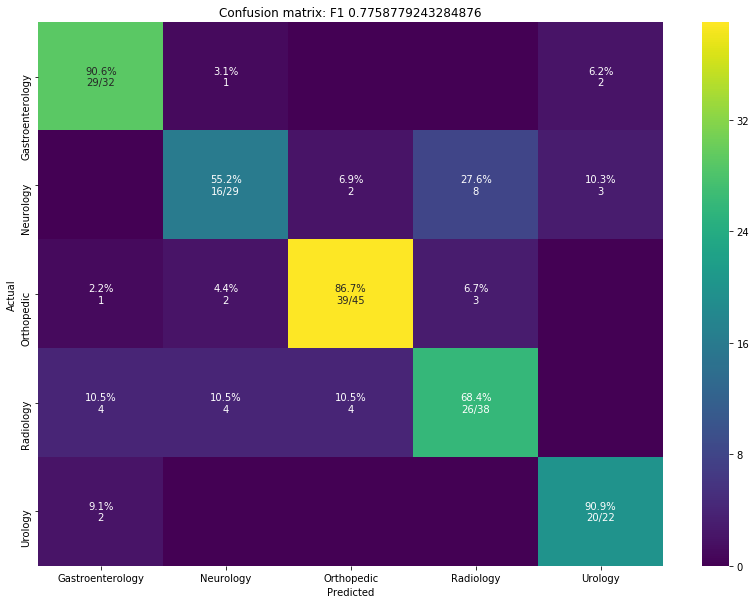

In [33]:
#print (confusion_matrix(valy, val_pred,labels=model.classes_))
plot_cm(df.label.iloc[val_idx],val_pred,y_labels,'Confusion matrix: F1 {}'.format(val_f1))

Our LSTM model achieves 77% F1 score on the validation data

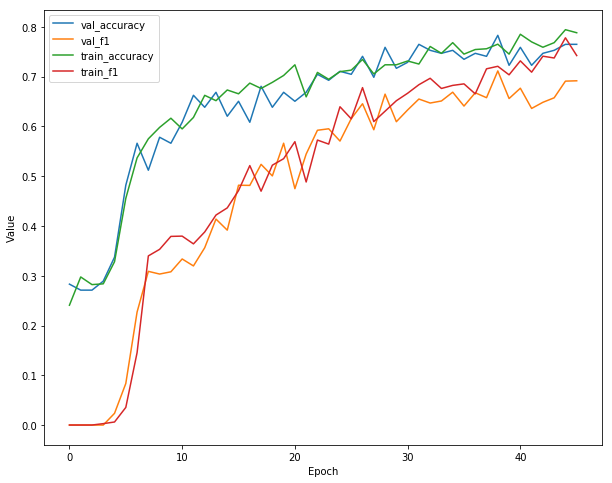

In [34]:
plt.figure(figsize=(10,8))
plt.plot(text_model.history.epoch, text_model.history.history['val_accuracy'],label='val_accuracy')
plt.plot(text_model.history.epoch, text_model.history.history['val_f1'],label='val_f1')
plt.plot(text_model.history.epoch, text_model.history.history['accuracy'],label='train_accuracy')
plt.plot(text_model.history.epoch, text_model.history.history['f1'],label='train_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

### Model interpretation

In [35]:
import eli5
from eli5.lime import TextExplainer

In [36]:
df.iloc[val_idx[:3]]['label']

0    Neurology 
1    Orthopedic
2    Orthopedic
Name: label, dtype: object

In [37]:
te = TextExplainer(random_state=42)
te.fit(df.clean_text.iloc[val_idx[0]], text_model.predict_proba)
te.show_prediction(target_names=y_labels)

In [38]:
te = TextExplainer(random_state=42)
te.fit(df.clean_text.iloc[val_idx[1]], text_model.predict_proba)
te.show_prediction(target_names=y_labels)

In [39]:
te = TextExplainer(random_state=42)
te.fit(df.clean_text.iloc[val_idx[2]], text_model.predict_proba)
te.show_prediction(target_names=y_labels)

### How to further improve our model

1. Add more LSTM layers or units
2. Add Convolution units to learn more features
3. Fine tune embeddings
4. Use different activation functions
5. Use learning rate scheduling techniques
6. Use different cost function to assign different weights to different classes.

and many more...

### References

1. https://colah.github.io/
2. http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
3. https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
